In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
filename = os.path.join("spectra", "ADP.2014-10-01T10:19:26.300.fits")
filename2 = os.path.join("spectra", "ADP.2014-10-01T10:19:48.717.fits")

hdul = fits.open(filename)
hdul2 = fits.open(filename2)

hdul.info()  # Print summary of extensions

# Explore structure - usually HARPS spectra are in the first extension or primary HDU
# For 1D extracted spectrum:

# Access the binary table in extension 1
table_data = hdul[1].data
columns = hdul[1].columns

table_data2 = hdul2[1].data
print(columns)

# Inspect column names
print(table_data.columns.names)

Filename: spectra/ADP.2014-10-01T10:19:26.300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3042   ()      
  1  SPECTRUM      1 BinTableHDU     45   1R x 3C   [313134D, 313134E, 313134E]   
ColDefs(
    name = 'WAVE'; format = '313134D'; unit = 'Angstrom'
    name = 'FLUX'; format = '313134E'; unit = 'adu'
    name = 'ERR'; format = '313134E'; unit = 'adu'
)
['WAVE', 'FLUX', 'ERR']


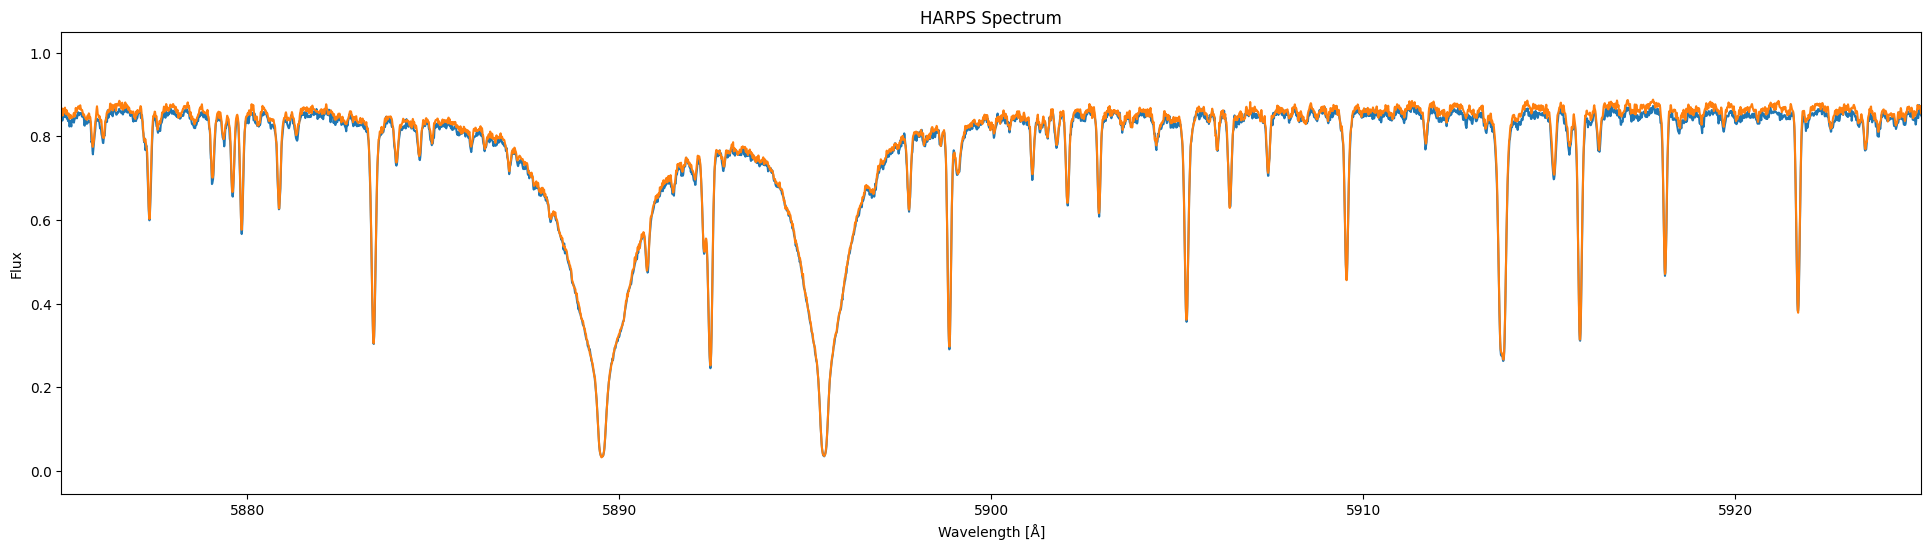

In [5]:
# Assuming columns are called 'WAVE', 'FLUX', 'ERR' (this is common)
wavelength = table_data['WAVE'][0]
flux = table_data['FLUX'][0]

wavelength2 = table_data2['WAVE'][0]
flux2 = table_data2['FLUX'][0]

plt.figure(figsize=(24,6))
plt.plot(wavelength, flux/np.max(flux))
plt.plot(wavelength2, flux2/np.max(flux2))
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("HARPS Spectrum")
plt.xlim(5875, 5925)
plt.show()

In [5]:
P = 304*10**(-6)
D = 0.125
lambda0 = 530*10**(-9)
P_angstrom = P * 1e10
D_angstrom = D * 1e10
lambda0_angstrom = lambda0 * 1e10

f_cutoff = (np.sqrt(2) / P_angstrom) * (D_angstrom / lambda0_angstrom)  # units: 1 / Å

# Check for uniform spacing
dw = np.diff(wavelength)
if not np.allclose(dw, dw[0], rtol=1e-4):
    raise ValueError("Wavelength grid is not evenly spaced — need to resample first.")

flux_fft = np.fft.fft(flux)
freqs = np.fft.fftfreq(len(flux), d=dw[0])
mask = np.abs(freqs)>f_cutoff
flux_fft_filtered = flux_fft.copy()
flux_fft_filtered[mask] = 0

# Inverse FFT
flux_filtered = np.fft.ifft(flux_fft_filtered).real

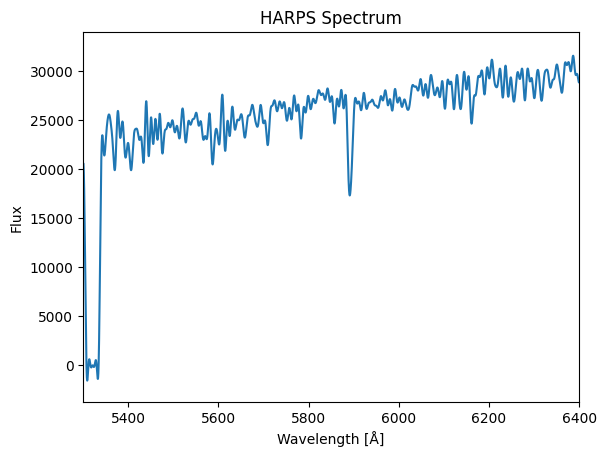

In [6]:
plt.plot(wavelength, flux_filtered)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("HARPS Spectrum")
plt.xlim(5300, 6400)
plt.show()

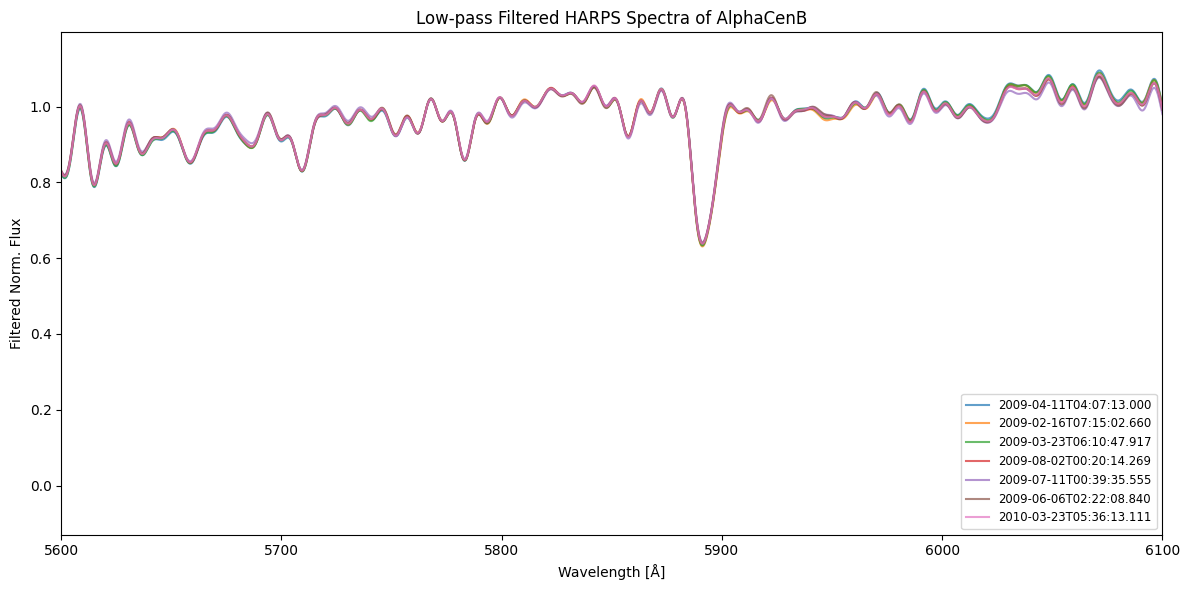

In [7]:
# --- Parameters ---
folder = "spectra2"
max_files = 20  # Set your desired limit
P = 304e-6       # meters
D = 0.125        # meters
lambda0 = 530e-9 # meters

# Convert to angstroms for consistency with wavelength array
P_A = P * 1e10
D_A = D * 1e10
lambda0_A = lambda0 * 1e10
f_cutoff = (np.sqrt(2) / P_A) * (D_A / lambda0_A)  # in 1 / Å

# --- Plot setup ---
plt.figure(figsize=(12, 6))
plotted = 0

# Loop over all .fits files in the folder
for filename in os.listdir(folder):
    if not filename.endswith(".fits"):
        continue
    if plotted >= max_files:
        break

    filepath = os.path.join(folder, filename)
    try:
        hdul = fits.open(filepath)
        data = hdul[1].data[0]  # Extension 1, first row of table
        wavelength = data['WAVE']
        flux = data['FLUX']

        # Define normalization window (in Å)
        # Perhaps do this after filtering.. but not sure
        # Nope, looks best to do this before filtering!!
        norm_min = 5300
        norm_max = 6400

        # Get mask for values within the range
        norm_mask = (wavelength >= norm_min) & (wavelength <= norm_max)

        # Prevent divide-by-zero if no values are in range
        if np.sum(norm_mask) < 10:
            print(f"Skipping {filename}: not enough points in normalization window.")
            continue

        # Compute median in range and normalize
        median_flux = np.median(flux[norm_mask])
        flux = flux / median_flux
        # Check for uniform spacing
        dw = np.diff(wavelength)
        if not np.allclose(dw, dw[0], rtol=1e-4):
            print(f"Skipping {filename}: wavelength grid not uniform.")
            continue

        # FFT and filtering
        flux_fft = np.fft.fft(flux)
        freqs = np.fft.fftfreq(len(flux), d=dw[0])
        mask = np.abs(freqs) > f_cutoff
        flux_fft[mask] = 0
        flux_filtered = np.fft.ifft(flux_fft).real

        # Plot the filtered spectrum
        # Get the observation date
        obs_date = hdul[0].header.get('DATE-OBS', 'Unknown')
        plt.plot(wavelength, flux_filtered, alpha=0.7, label=obs_date)

        plotted += 1

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

# --- Finalize plot ---
plt.xlabel("Wavelength [Å]")
plt.ylabel("Filtered Norm. Flux")
plt.title(f"Low-pass Filtered HARPS Spectra of AlphaCenB")
plt.legend(fontsize='small', loc='lower right')
plt.xlim(5600,6100)
plt.tight_layout()
#plt.savefig('somespectra.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# it looks like the spectrum barely changes whatsoever over the period of 1 year.
# the relative amplitudes of certain wavelengths increases/decreases
# but there isn't really any shift whatsoever in the main parts of the spectrum
# all absorption lines remain almost exactly the same to this resolution.
# need to quantify just how much.